## Looking Around

This code solves the QLC problem in Fourier space. Parameters include:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time
from scipy.fft import fftfreq, rfftfreq
from scipy.fft import rfft, irfft

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [2]:
%matplotlib widget # %matplotlib notebook backend is deprecated for jupyter notebook: use widget instead
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

### Getting parameters for this run

In [4]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.21 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [11]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

### Varibles that depend on the above

In [12]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Runtime parameters from the namelist 

In [13]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 30 millisecond
This is a run from time 0.0 millisecond to 30.0 millisecond
dt = 612.2448979591836 microsecond


### Exercising the library

In [14]:
# Get the equilibrium value of NQLL
Ntot = 1.1
print('When Ntot =', Ntot)
NQLL_eq = QLC.getNQLL(Ntot,Nstar,Nbar)
print('The equilibrium value of NQLL is ', NQLL_eq)

# Get the difference in NQLL relative to the equilibrium
NQLL = 0.7
print('When the actual NQLL is ', NQLL)
print('The difference from equilibrium of NQLL is ', QLC.getDeltaNQLL(Ntot,Nstar,Nbar,NQLL))

# Supersaturation
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
print('sigmaI_QLC',sigmaI_QLC[0:10])

When Ntot = 1.1
The equilibrium value of NQLL is  0.9412214747707527
When the actual NQLL is  0.7
The difference from equilibrium of NQLL is  -0.24122147477075273
sigmaI_QLC [0.20999999999999996 0.2099868751289787 0.209973832804316 0.20996087302601193 0.2099479957940665 0.20993520110847966 0.20992248896925148 0.2099098593763819 0.20989731232987094 0.20988484782971864] dimensionless


### Run the scenario in Cartesian space

10 % elapsed time is 0.005 minutes
20 % elapsed time is 0.007 minutes
30 % elapsed time is 0.010 minutes
40 % elapsed time is 0.013 minutes
50 % elapsed time is 0.016 minutes
60 % elapsed time is 0.019 minutes
70 % elapsed time is 0.022 minutes
80 % elapsed time is 0.025 minutes
90 % elapsed time is 0.028 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


<IPython.core.display.Javascript object>


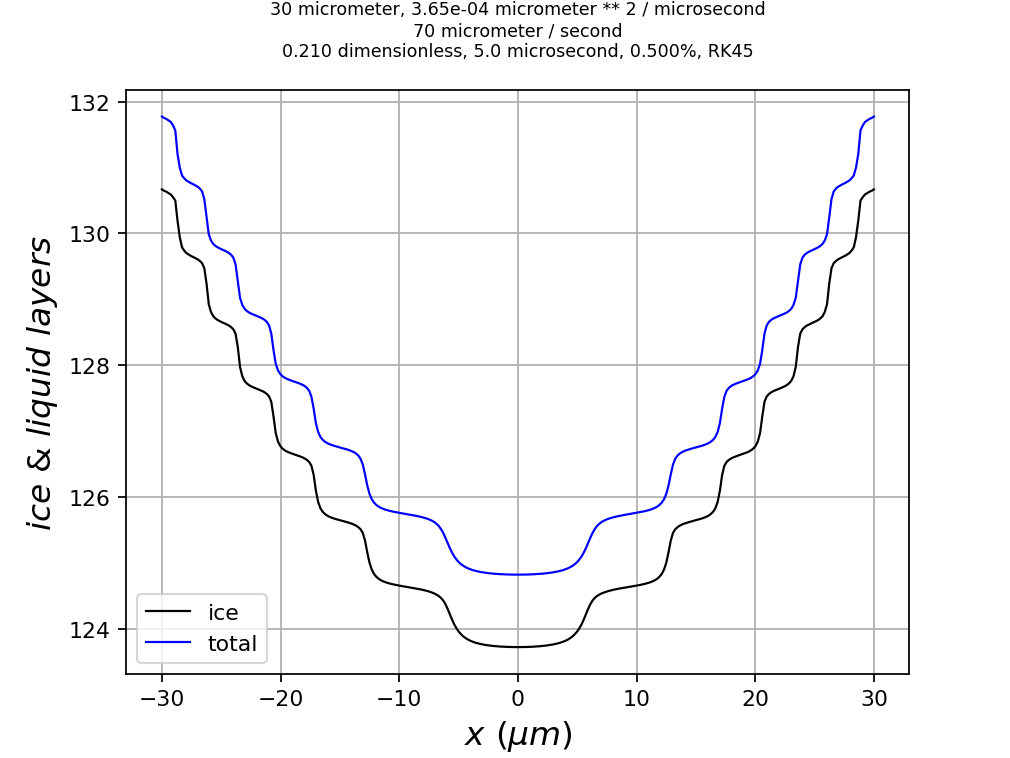

<IPython.core.display.Javascript object>


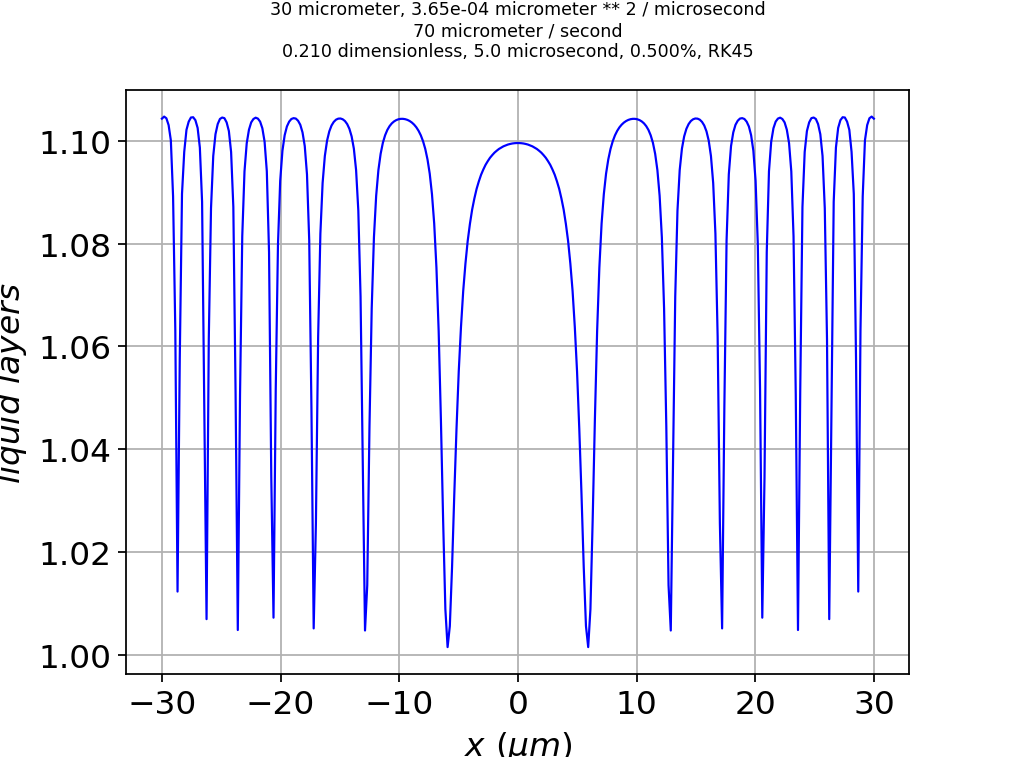

<IPython.core.display.Javascript object>


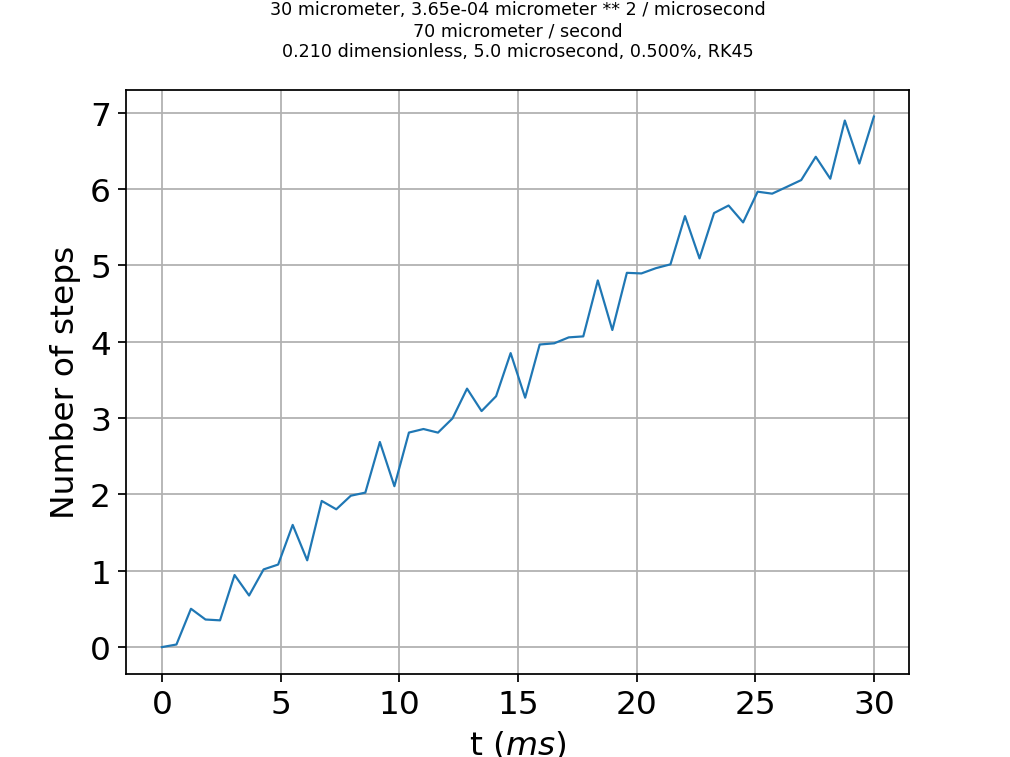

In [7]:
Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Reporting and graphing
# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r.to('percent').magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)